# Prior and (noisy) posterior predictions

Show the difference between noisy and noiseless predictions by plotting. Now
we generate 1$D$ toy data $(x_i\in\mathbb R, y_i\in\mathbb R)$ and also
perform a "real GP fit" by optimizing the $\ell$ hyperparameter. However we fix
$\sigma_n^2$ to certain values to showcase the different noise cases.

Below $\ma\Sigma\equiv\cov(\ve f_*)$ is the covariance matrix from
{cite}`rasmussen_2006_GaussianProcessesMachine` eq. 2.24 with $\ma K =
K(X,X)$, $\ma K'=K(X_*, X)$ and $\ma K''=K(X_*, X_*)$, so

$$\ma\Sigma = \ma K'' - \ma K'\,(\ma K+\sigma_n^2\,\ma I)^{-1}\,\ma K'^\top$$

Imports and helpers

In [1]:
from functools import partial

from box import Box

import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib import is_interactive

from common import (
    textbook_prior,
    textbook_posterior,
    textbook_posterior_noise,
    cov2std,
    sample_y,
)

plt.rcParams["figure.autolayout"] = True
plt.rcParams["font.size"] = 18


def transform_labels(name: str):
    lmap = dict(
        noise_level=r"$\sigma_n^2$",
        length_scale=r"$\ell$",
        y_std_pn=r"$\sqrt{\mathrm{diag}(\Sigma)}$",
        y_std_p=r"$\sqrt{\mathrm{diag}(\Sigma + \sigma_n^2\,I)}$",
        y_mean=r"$\mu$",
    )
    return lmap.get(name, name)


def gt_func(x):
    """Ground truth"""
    return np.sin(x) * np.exp(-0.1 * x) + 10


def transform_1d(scaler: StandardScaler, x):
    assert x.ndim == 1
    return scaler.transform(x.reshape(-1, 1))[:, 0]


def calc_gp(
    *,
    pri_post: bool,
    noise_level: float,
    pred_mode: str,
    XI: np.ndarray,
    X: np.ndarray = None,
    y: np.ndarray = None,
):
    if pri_post == "pri":
        length_scale = 0.5
        gp = GaussianProcessRegressor(
            kernel=RBF(length_scale=length_scale)
            + WhiteKernel(noise_level=noise_level),
            alpha=0,
            normalize_y=False,
        )
    elif pri_post == "post":
        gp = GaussianProcessRegressor(
            kernel=RBF(length_scale_bounds=[1e-5, 10])
            + WhiteKernel(noise_level=noise_level, noise_level_bounds="fixed"),
            n_restarts_optimizer=5,
            alpha=0,
            normalize_y=False,
        )

        gp.fit(X, y)
        length_scale = gp.kernel_.k1.length_scale
        # gp.kernel_.k2.noise_level == noise_level (fixed)
    else:
        raise ValueError(f"unknown {pri_post=}")

    y_mean, y_cov = gp.predict(XI, return_cov=True)

    if pred_mode == "p":
        post_ref_func = textbook_posterior_noise
    elif pred_mode == "pn":
        post_ref_func = textbook_posterior
        y_cov -= np.eye(XI.shape[0]) * noise_level
    else:
        raise ValueError(f"unknown {pred_mode=}")

    y_std_label = transform_labels(f"y_std_{pred_mode}")
    y_std = cov2std(y_cov)

    if pri_post == "pri":
        y_mean_ref, y_std_ref, y_cov_ref = textbook_prior(
            noise_level=noise_level, length_scale=length_scale
        )(XI)
    else:
        y_mean_ref, y_std_ref, y_cov_ref = post_ref_func(
            X, y, noise_level=noise_level, length_scale=length_scale
        )(XI)

    np.testing.assert_allclose(y_mean, y_mean_ref, rtol=0, atol=1e-9)
    np.testing.assert_allclose(y_std, y_std_ref, rtol=0, atol=1e-9)
    np.testing.assert_allclose(y_cov, y_cov_ref, rtol=0, atol=1e-9)

    samples = sample_y(y_mean, y_cov, 10, random_state=123)

    if pri_post == "pri":
        if noise_level == 0:
            cov_title = r"$\Sigma=K''$"
        else:
            cov_title = r"$\Sigma=K'' + \sigma_n^2$"
    else:
        if noise_level == 0:
            cov_title = r"$\Sigma=K'' - K'\,K^{-1}\,K'^\top$"
        else:
            cov_title = r"$\Sigma=K'' - K'\,(K+\sigma_n^2\,I)^{-1}\,K'^\top$"

    cov_title += "\n" + rf"$\sigma$={y_std_label}"

    return Box(
        y_mean=y_mean,
        y_cov=y_cov,
        y_std=y_std,
        samples=samples,
        cov_title=cov_title,
        length_scale=length_scale,
        noise_level=noise_level,
        y_std_label=y_std_label,
        pri_post=pri_post,
    )


def plot_gp(
    *, box: Box, ax, xi, std_color="tab:orange", x=None, y=None, set_title=True
):
    if set_title:
        ax.set_title(
            f"{transform_labels('noise_level')}={box.noise_level}   "
            f"{transform_labels('length_scale')}={box.length_scale:.5f}"
            "\n" + box.cov_title
        )

    samples_kind = "prior" if box.pri_post == "pri" else "posterior"
    for ii, yy in enumerate(box.samples.T):
        ax.plot(
            xi,
            yy,
            color="tab:gray",
            alpha=0.3,
            label=(f"{samples_kind} samples" if ii == 0 else "_"),
        )

    ax.plot(
        xi,
        box.y_mean,
        lw=3,
        color="tab:red",
        label=transform_labels("y_mean"),
    )

    if box.pri_post == "post":
        ax.plot(x, y, "o", ms=10)

    ax.fill_between(
        xi,
        box.y_mean - 2 * box.y_std,
        box.y_mean + 2 * box.y_std,
        alpha=0.1,
        color=std_color,
        label=rf"$\pm$ 2 {box.y_std_label}",
    )

Generate 1$D$ toy data

In [2]:
seed = 123
rng = np.random.default_rng(seed=seed)

x = np.sort(rng.uniform(0, 5, 5), axis=0)
xspan = x.max() - x.min()
xi = np.linspace(x.min() - 0.3 * xspan, x.max() + 0.3 * xspan, len(x) * 50)
y = gt_func(x)

in_scaler = StandardScaler().fit(x.reshape(-1, 1))
out_scaler = StandardScaler().fit(y.reshape(-1, 1))
x = transform_1d(in_scaler, x)
xi = transform_1d(in_scaler, xi)
y = transform_1d(out_scaler, y)
X = x[:, None]
XI = xi[:, None]

noise_level = 0.3
y_lim = (-3, 3)

First we plot the prior, without noise (`predict_noiseless`).

This is the standard textbook case. We set $\ell$ to some constant of our
liking since its value is not defined in the absence of training data.

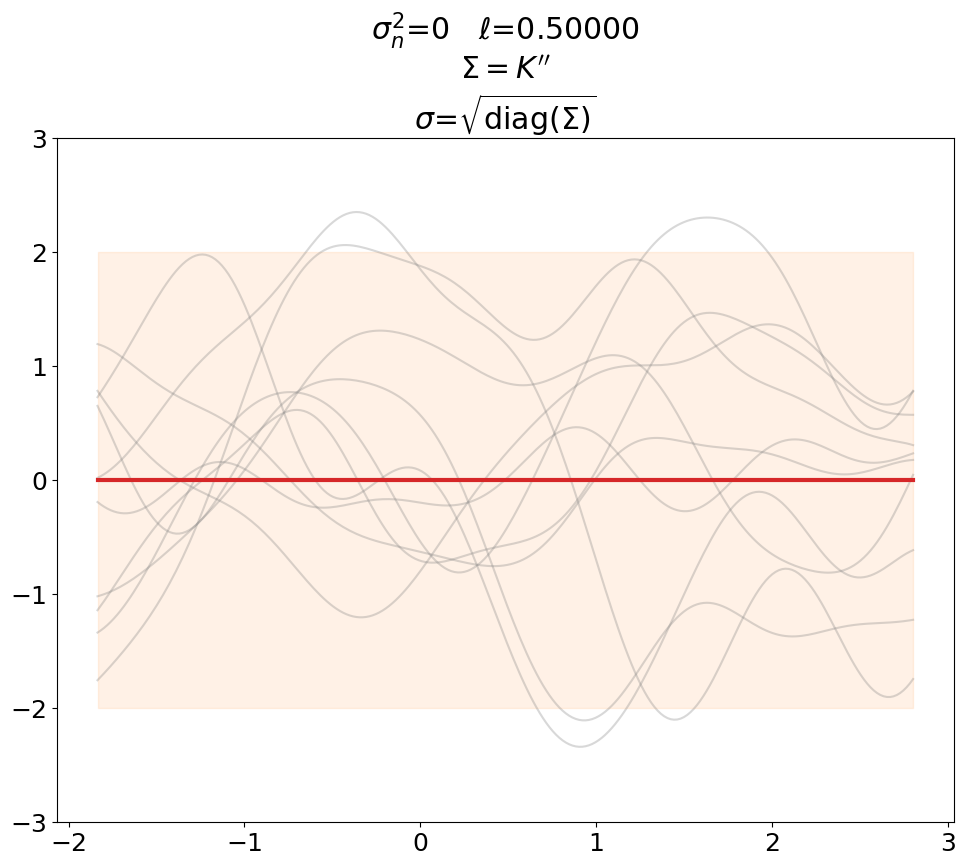

In [3]:
# -----------------------------------------------------------------------
# prior
# -----------------------------------------------------------------------

figsize_single = (10, 9)

d_pri_0 = calc_gp(
    pri_post="pri",
    noise_level=0,
    pred_mode="pn",
    XI=XI,
)

fig, ax = plt.subplots(figsize=figsize_single)
plot_gp(box=d_pri_0, ax=ax, xi=xi)
_ = ax.set_ylim(*y_lim)

Even though not super useful, we can certainly generate noisy prior samples
in the `predict` setting when using $\ma K'' + \sigma_n^2\,\ma I$ as prior
covariance.

This is also shown in {cite}`deisenroth_2020_PracticalGuideGaussian` in fig. 4.

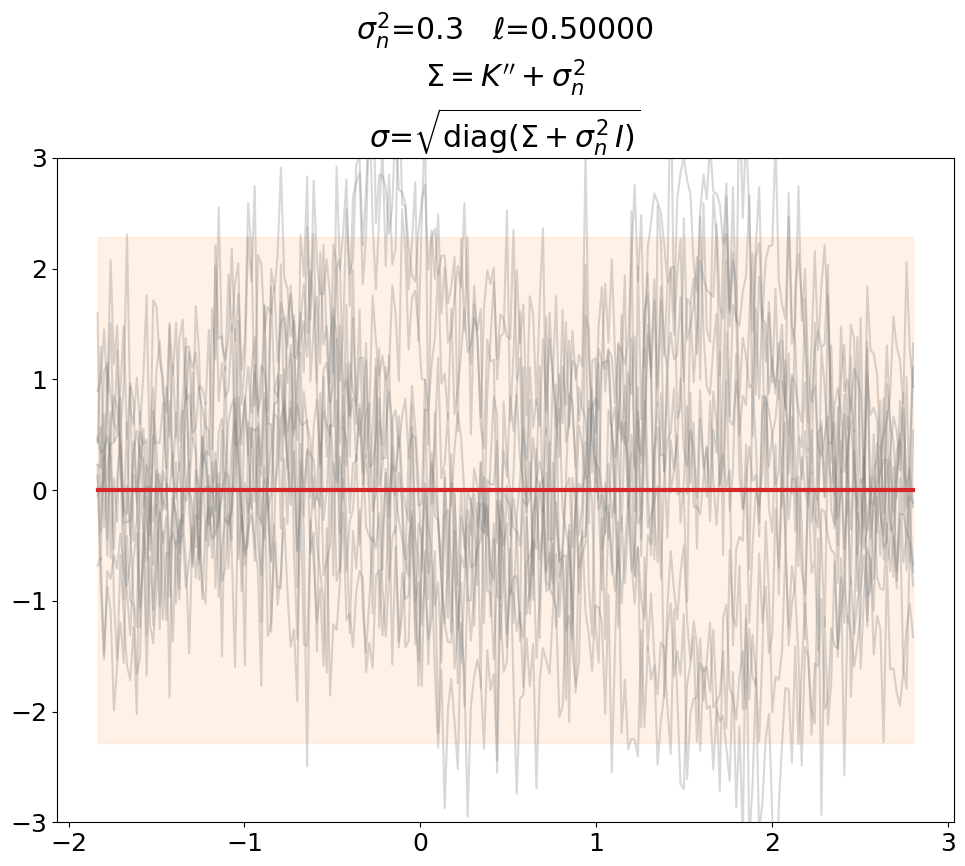

In [4]:
d_pri_p = calc_gp(
    pri_post="pri",
    noise_level=noise_level,
    pred_mode="p",
    XI=XI,
)

fig, ax = plt.subplots(figsize=figsize_single)
plot_gp(box=d_pri_p, ax=ax, xi=xi)
_ = ax.set_ylim(*y_lim)

Now the posterior.

For that, we do an $\ell$ optimization using 1$D$ toy data and `sklearn`
with fixed $\sigma_n^2$:
* interpolation ($\sigma_n = 0$)
* regression ($\sigma_n > 0$)

In [5]:
# -----------------------------------------------------------------------
# posterior
# -----------------------------------------------------------------------

calc_gp_post = partial(calc_gp, X=X, y=y, XI=XI)
d_post_0 = calc_gp_post(
    pri_post="post",
    noise_level=0,
    pred_mode="pn",
)

d_post_p = calc_gp_post(
    pri_post="post",
    noise_level=noise_level,
    pred_mode="p",
)

d_post_pn = calc_gp_post(
    pri_post="post",
    noise_level=noise_level,
    pred_mode="pn",
)

y_std_p_color = "tab:cyan"
y_std_pn_color = "tab:orange"
plot_gp_post = partial(plot_gp, x=x, y=y, xi=xi)

Interpolation ($\sigma_n^2=0$).

This is a plot you will see in most text books. Notice that $\ell$ is not
0.5 as above but has been optimized (maximal LML).

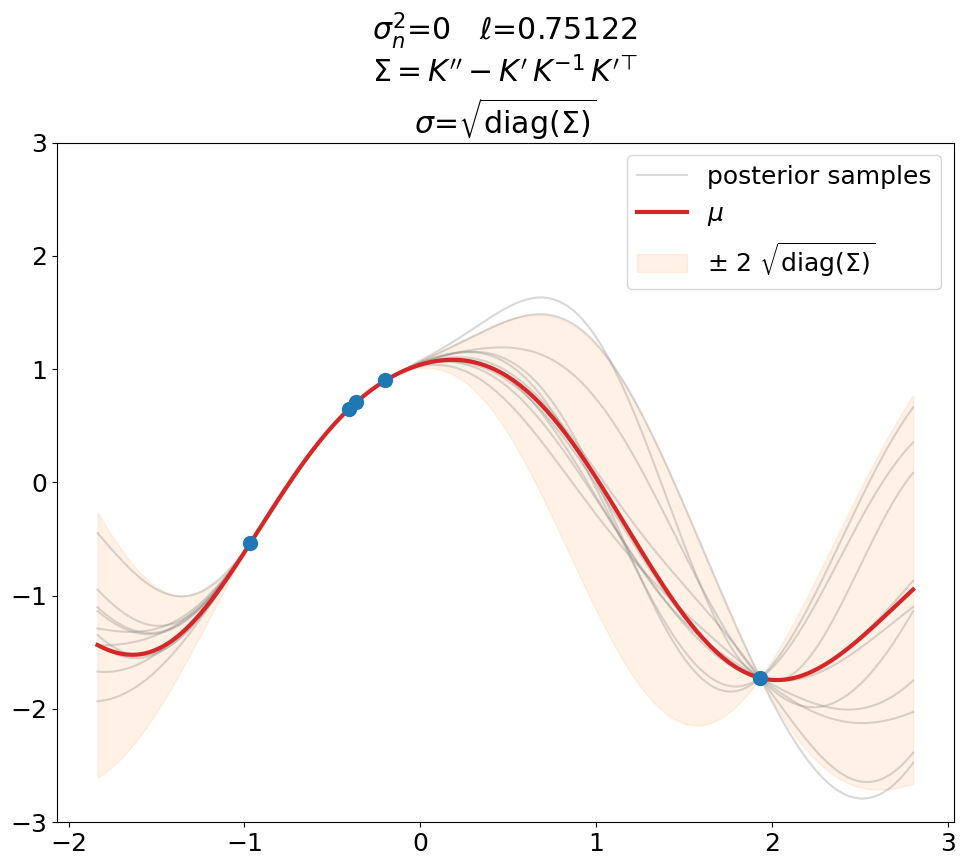

In [6]:
fig, ax = plt.subplots(figsize=figsize_single)
plot_gp_post(box=d_post_0, ax=ax)
ax.legend(loc="upper right")
_ = ax.set_ylim(*y_lim)

Regression ($\sigma_n^2>0$), `predict_noiseless`.

You will see a plot like this also in text books. For instance
{cite}`murphy_2023_ProbabilisticMachineLearningAdvanced` has this in fig.
18.7 (book version 2022-10-16). If you inspect the code that generates it
(which is open source, thanks!), you find that they use tinygp in the
`predict_noiseless` setting.

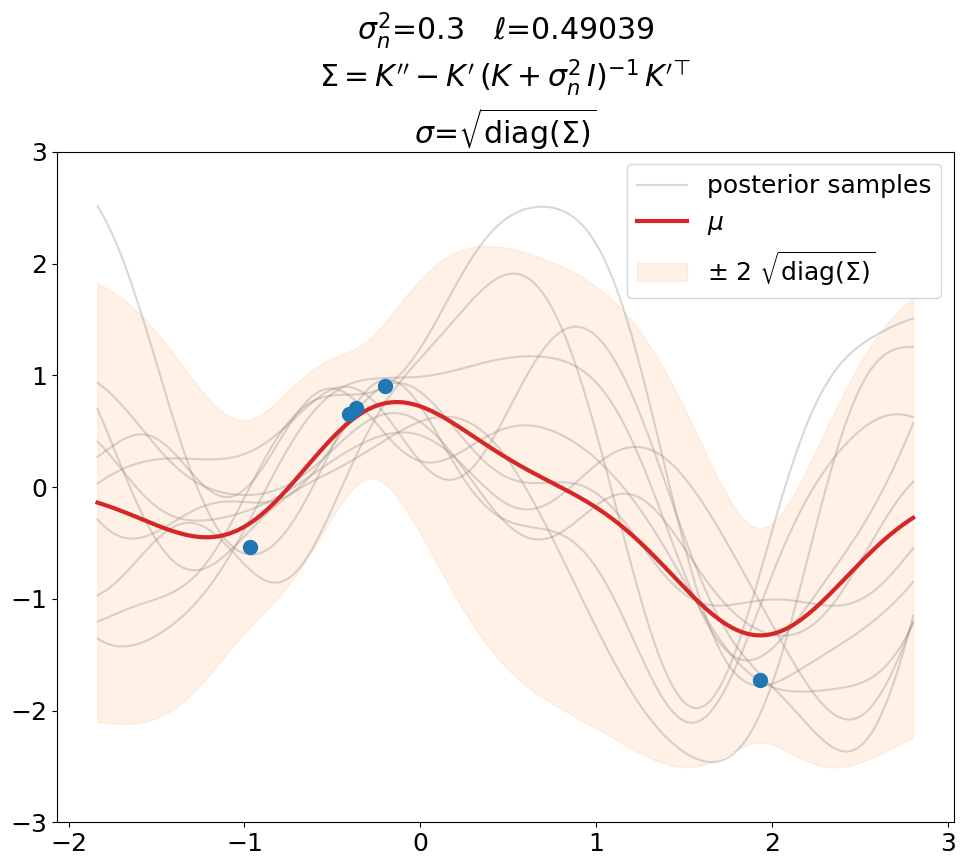

In [7]:
fig, ax = plt.subplots(figsize=figsize_single)
plot_gp_post(box=d_post_pn, ax=ax)
ax.legend(loc="upper right")
_ = ax.set_ylim(*y_lim)

Regression ($\sigma_n^2>0$), `predict`.

This is the same as above in terms of optimized $\ell$, $\sigma_n^2$ value
(fixed here, usually also optimized), fit weights $\ve\alpha$ and thus
predictions $\ve\mu$.

The only difference is that we now use the covariance matrix $\ma\Sigma +
\sigma_n^2\,\ma I$ instead of $\ma\Sigma$ to generate samples from the
posterior. By that we get (1) noisy samples and (2) a larger $\sigma$. That's
what is typically *not* shown in text books (at least not the ones we
checked). Noisy samples (only for the *prior*, but still) are shown for
instance in {cite}`deisenroth_2020_PracticalGuideGaussian` in fig. 4.

The difference in $\sigma$ between `predict` vs. `predict_noiseless` is not
constant even though the constant $\sigma_n^2$ is added to the diagonal
because of the $\sqrt{\cdot}$ in

$$\sigma = \sqrt{\mathrm{diag}(\cov(\ve f_*) + \sigma_n^2\ma I)}$$

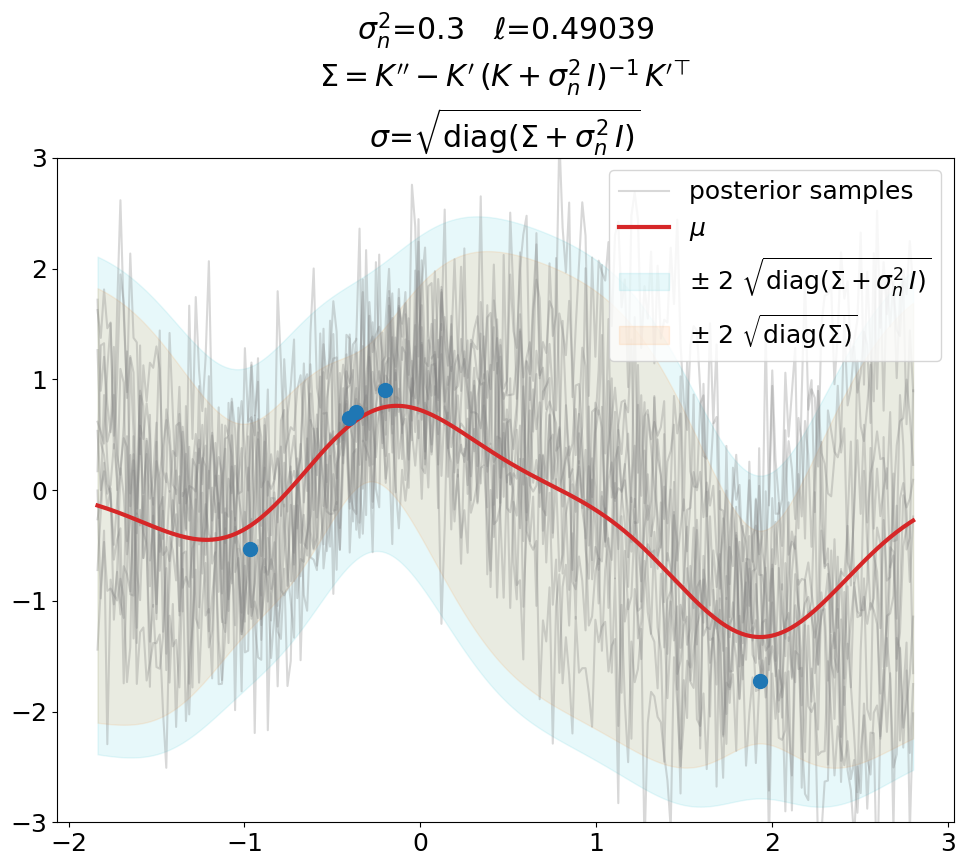

In [8]:
fig, ax = plt.subplots(figsize=figsize_single)
plot_gp_post(box=d_post_p, ax=ax, std_color=y_std_p_color)
dd = d_post_pn
ax.fill_between(
    xi,
    dd.y_mean - 2 * dd.y_std,
    dd.y_mean + 2 * dd.y_std,
    alpha=0.1,
    color=y_std_pn_color,
    label=rf"$\pm$ 2 {dd.y_std_label}",
)
ax.legend(loc="upper right")
_ = ax.set_ylim(*y_lim)

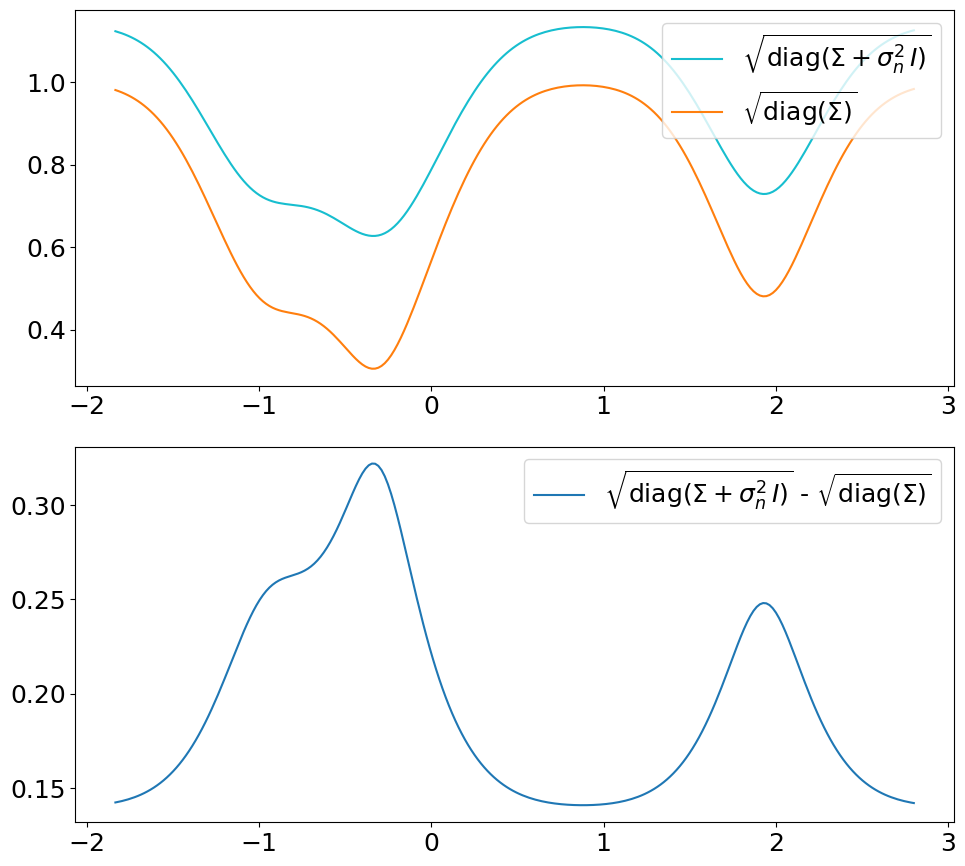

In [9]:
fig, axs = plt.subplots(nrows=2, figsize=figsize_single)
for dd, color in [(d_post_p, y_std_p_color), (d_post_pn, y_std_pn_color)]:
    axs[0].plot(xi, dd.y_std, label=dd.y_std_label, color=color)

aa = d_post_p
bb = d_post_pn
axs[1].plot(
    xi, aa.y_std - bb.y_std, label=f"{aa.y_std_label} - {bb.y_std_label}"
)
for ax in axs:
    ax.legend(loc="upper right")


# Compact plot in one fig.
#
##fig, axs = plt.subplots(
##    nrows=3,
##    ncols=3,
##    gridspec_kw=dict(height_ratios=[1, 0.3, 0.3]),
##    figsize=(30, 15),
##    sharex=True,
##)
##
##
##plot_gp_post = partial(plot_gp, x=x, y=y, xi=xi)
##plot_gp_post(box=d_post_0, ax=axs[0, 0])
##plot_gp_post(box=d_post_pn, ax=axs[0, 1])
##plot_gp_post(box=d_post_p, ax=axs[0, 2], std_color=y_std_p_color)
##
##dd = d_post_pn
##axs[0, 2].fill_between(
##    xi,
##    dd.y_mean - 2 * dd.y_std,
##    dd.y_mean + 2 * dd.y_std,
##    alpha=0.1,
##    color=y_std_pn_color,
##    label=rf"$\pm$ 2 {dd.y_std_label}",
##)
##
##for dd, color in [(d_post_p, y_std_p_color), (d_post_pn, y_std_pn_color)]:
##    axs[1, 2].plot(xi, dd.y_std, label=dd.y_std_label, color=color)
##
##aa = d_post_p
##bb = d_post_pn
##axs[2, 2].plot(
##    xi, aa.y_std - bb.y_std, label=f"{aa.y_std_label} - {bb.y_std_label}"
##)
##
##for ax in axs[1:, :2].flat:
##    ax.set_visible(False)
##
##for ax in [axs[0, 1], axs[0, 2], axs[1, 2], axs[2, 2]]:
##    ax.legend(loc="upper right")
##
##for ax in axs[0, :]:
##    ax.set_ylim(-3, 3)
##
##for ax in axs[1, :].flat:
##    ax.set_ylim(-0.1, 1.3)
##
##for ax in axs[2, :].flat:
##    ax.set_ylim(-0.1, 0.5)

### Make logo
##fig, ax = plt.subplots()
##plot_gp_post(box=d_post_pn, ax=ax, set_title=False)
##ax.set_axis_off()
##fig.savefig("logo.png", dpi=150)

if not is_interactive():
    plt.show()